In [8]:
# Standard Python modules
import os, sys
import yaml
import glob
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../../modules')
from ar_funcs import AR_rank
# from wrf_preprocess import preprocess_PCPT_new
import nclcmaps as nclc
from plotter import draw_basemap
from wrf_preprocess import preprocess_2Dvar

In [6]:
# Set up paths
server = 'skyriver'
if server == 'skyriver':
    path_to_data = '/work/dnash/data/' 
elif server == 'comet':
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
    path_to_work = '/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/SEAK-WRF-precip/'
path_to_out  = '../../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../../figs/'      # figures

## Import Data

### 4 km WRF

In [9]:
if server == 'skyriver':
    # get list of filenames that contain data from that year from current year folder
    filenames = []
    path_to_wrf = path_to_data + 'downloads/wrf-AK/'
    for name in glob.glob(path_to_wrf + 'WRFDS_2018-01-*'):
        filenames.append(name)
    # sort filenames so they are in chronological order
    filenames = sorted(filenames)
    print(filenames)
    wrf = preprocess_2Dvar(filenames, 'PCPT')
elif server == 'comet':
    filenames = []
    for name in glob.glob(path_to_data + 'downloads/SEAK-WRF/2018/WRFDS_2018-01-1*.nc'):
        filenames.append(name)
    # sort filenames so they are in chronological order
    filenames = sorted(filenames)
    print(filenames)
    wrf = preprocess_2Dvar(filenames, 'PCPT')

# select only January 11-16
wrf = wrf.sel(time=slice('2018-01-11', '2018-01-16'))
wrf

['/work/dnash/data/downloads/wrf-AK/WRFDS_2018-01-11.nc', '/work/dnash/data/downloads/wrf-AK/WRFDS_2018-01-12.nc', '/work/dnash/data/downloads/wrf-AK/WRFDS_2018-01-13.nc', '/work/dnash/data/downloads/wrf-AK/WRFDS_2018-01-14.nc', '/work/dnash/data/downloads/wrf-AK/WRFDS_2018-01-15.nc', '/work/dnash/data/downloads/wrf-AK/WRFDS_2018-01-16.nc']


<xarray.Dataset>
Dimensions:  (time: 144, y: 250, x: 320)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-11 ... 2018-01-16T23:00:00
    lat      (y, x) float32 53.12 53.12 53.13 53.13 ... 61.97 61.97 61.96 61.95
    lon      (y, x) float32 -148.1 -148.0 -147.9 -147.9 ... -126.4 -126.3 -126.3
Dimensions without coordinates: y, x
Data variables:
    PCPT     (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 2
    date:     Thu Jun 27 12:11:38 AKDT 2019

In [10]:
wrf = wrf.sum('time') # storm total precipitation
print('Max storm total:', wrf.PCPT.max().values)

Max storm total: 691.5


### 27 km ERA5

In [18]:
## Choose case study
## get filenames for IVT and Precip
month='jan'
year = 2018
datelst = ['0111', '0112', '0113', '0114', '0115', '0116'] # january 2018 Skagway event
ext1 = [-141., -130., 54., 60.] # extent of SEAK
era_filenames = []

for i, monthday in enumerate(datelst):
    era_filenames.append('/data/downloaded/Reanalysis/ERA5/{0}/{2}/ERA5_{0}_{2}{1}.nc'.format('Precip', monthday, str(year)))
    
    
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(ext1[2], ext1[3]), lon=slice(ext1[0], ext1[1]))

# Open dataset using xarray
era = xr.open_mfdataset(era_filenames, preprocess=preprocess, combine='by_coords')
era

<xarray.Dataset>
Dimensions:  (time: 144, lat: 25, lon: 45)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-11 ... 2018-01-16T23:00:00
  * lat      (lat) float64 54.0 54.25 54.5 54.75 55.0 ... 59.25 59.5 59.75 60.0
  * lon      (lon) float64 -141.0 -140.8 -140.5 -140.2 ... -130.5 -130.2 -130.0
Data variables:
    TP       (time, lat, lon) float64 dask.array<chunksize=(24, 25, 45), meta=np.ndarray>
Attributes:
    Conventions:  CF-1/0

In [19]:
era = era.sum('time') # storm total precipitation
print('Max storm total:', era.TP.max().values)

Max storm total: 228.12093244872153


## Plot storm total precipitation

In [22]:
# Set up projection
mapcrs = ccrs.Mercator()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lonmax, lonmin, latmin, latmax = ext1 # extent of SEAK
dx = np.arange(lonmax,lonmin+2,2)
dy = np.arange(latmin,latmax+1,1)

data = [era, wrf]
varname_lst = ['TP', 'PCPT']

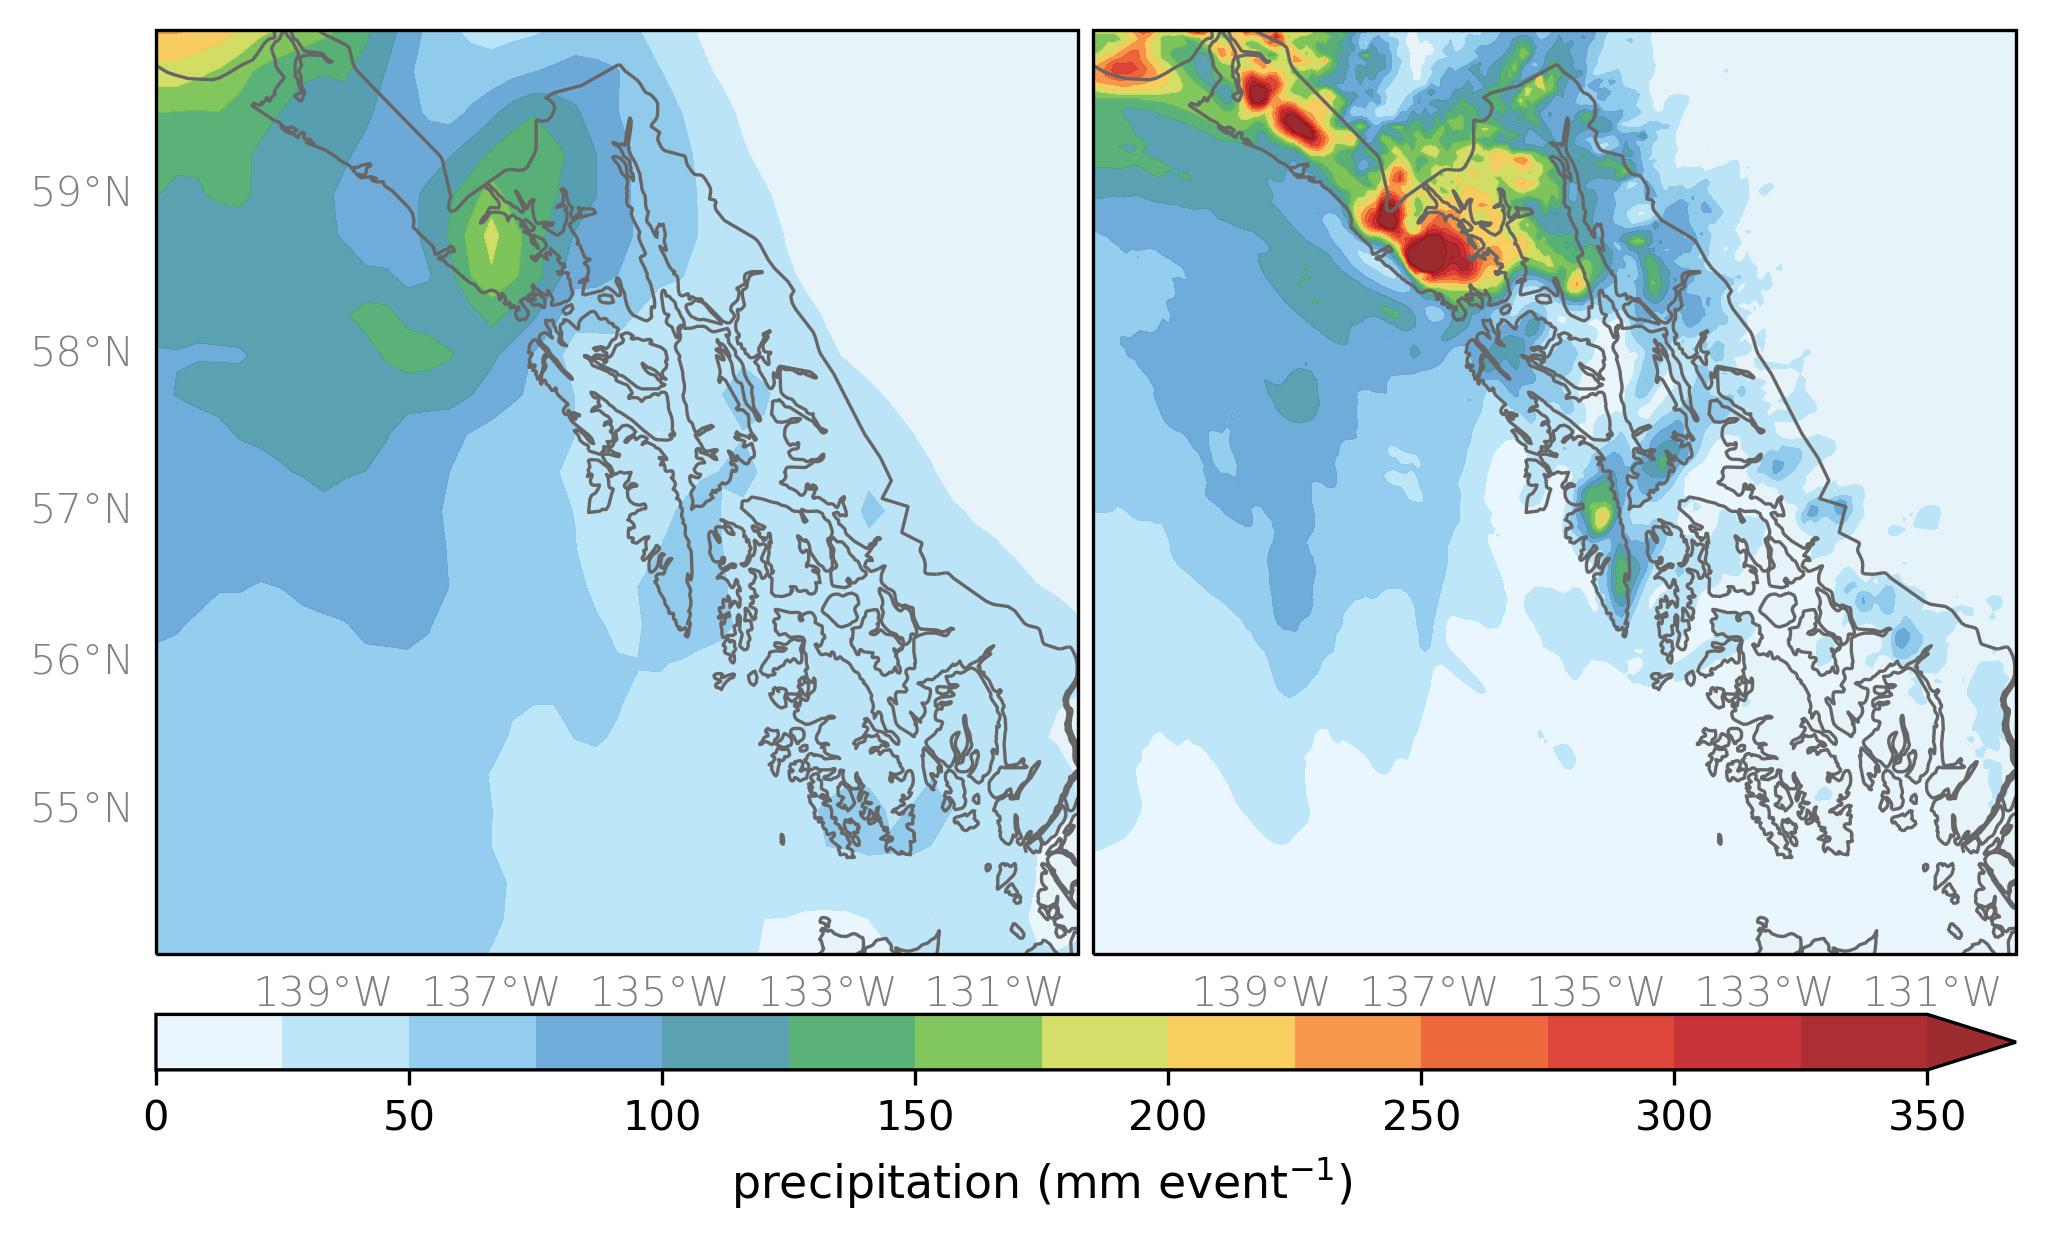

In [31]:
# Create figure
fig = plt.figure(figsize=(8, 8))
fig.dpi = 300
fname = path_to_figs + 'era5_WRF_comparison'
fmt = 'png'

nrows = 1
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.15, cbar_size='3%',label_mode='')

left_lats = [True, False]
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=left_lats[k], right_lats=False)

    # Contour Filled
    prec = data[k][varname_lst[k]].values
    lats = data[k].lat.values
    lons = data[k].lon.values
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=np.arange(0, 375, 25), cmap=nclc.cmap('WhiteBlueGreenYellowRed'), alpha=0.9, extend='max')


# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label('precipitation (mm event$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()